# Jupyter Notebook per Abilità Informatiche
Progetto Covid-19, regione Puglia

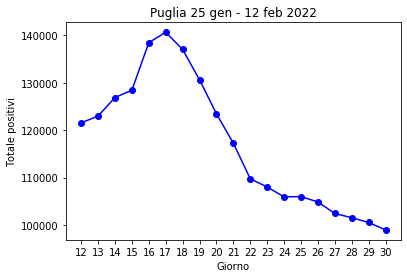

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy
from scipy.stats import poisson
import statistics

x = []
y = []

#leggo i dati 
for line in open('daticovid.txt', 'r'):
    lines = [i for i in line.split()]
    x.append(lines[0])
    y.append(int(lines[1]))
    
#plot totale dei positivi nel periodo considerato
plt.title("Puglia 25 gen - 12 feb 2022")
plt.xlabel('Giorno')
plt.ylabel('Totale positivi')
plt.plot(x, y, marker = 'o', c = 'b')
  
plt.show()

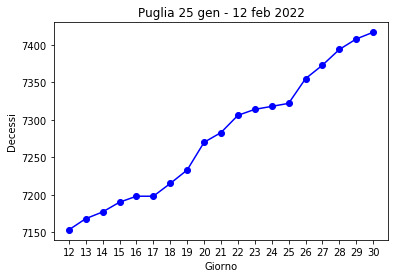

In [2]:
x=[]
y=[]

#leggo i dati 
for line in open('decessi.txt', 'r'):
    lines = [i for i in line.split()]
    x.append(lines[0])
    y.append(int(lines[1]))
    
#plot totale dei positivi nel periodo considerato
plt.title("Puglia 25 gen - 12 feb 2022")
plt.xlabel('Giorno')
plt.ylabel('Decessi')
plt.plot(x, y, marker = 'o', c = 'b')
  
plt.show()

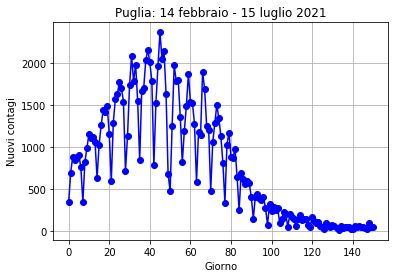

In [3]:
x=[]
y=[]


#leggo i dati 
for line in open('test.txt', 'r'):
    lines = [i for i in line.split()]
    x.append(int(lines[1]))
    y.append(int(lines[0]))
    
for i in range(0,151):
    x[i]=x[i]-357

#std=statistics.stdev(y)
#plot dei nuovi positivi nel periodo considerato
plt.title("Puglia: 14 febbraio - 15 luglio 2021")
plt.xlabel('Giorno')
plt.ylabel('Nuovi contagi')
plt.plot(x, y, marker = 'o', c = 'b')
plt.grid()
plt.show()

In [4]:
#definisco la funzione di Gompertz
#x0 -> giorno in cui è partito il contagio con N0=1 caso
def Gomp(i,K,r,x0):
    c=np.log(1./K)
    g=K*np.exp(c*np.exp(-r*np.array(x[i]-x0)))
    return g


#differenze finite funzione di Gompertz
def diff_Gomp(i,K,r,x0):
    h = Gomp(x[i+1],K,r,x0)-Gomp(x[i],K,r,x0)
    return h


In [5]:
#definisco la funzione che calcola la log-likelihood 
#assumo che il set di dati sui nuovi contagi sia descritto da una poissoniana
#devo calcolare la prob di avere il numero di nuovi contagi osservato con una media data dalla valutazione di diff_gomp
#punto per punto, cioé giorno per giorno.
def likelihood(x,y,theta):
    K, r, x0 = theta

    l=[None]*150
    z=[None]*150
    #poisson.pmf(k,m)-> k è l'evento, m la media
    for i in range(0,150):
        #print(y[i],diff_Gomp(x[i],K,r,x0),x[i],K,r,x0)
        z[i]=poisson.pmf(y[i],diff_Gomp(x[i],K,r,x0))
        l[i]=np.log(z[i])
    return np.nansum(l)

In [6]:
#definisco un flat (uninformative) prior sui parametri
def log_prior(theta):
    K, r, x0 = theta
    if x0 < 0. and r >0. and K>0.:
        return 0.0
    return -np.inf


def log_pos(theta, x, y):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + likelihood(x,y,theta)

theta = [100000.,0.05,-15]


#print(diff_Gomp(i,*theta))
print(log_pos(theta,x,y))

-13572.351356930412


In [7]:
from scipy.optimize import minimize

np.random.seed(42)
nll = lambda *args: -log_pos(*args)
initial = theta
soln = minimize(nll, initial, args=(x, y))
print(soln.x)


C:\Users\anton\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


[ 1.22260969e+05  3.99578178e-02 -2.70483987e+01]


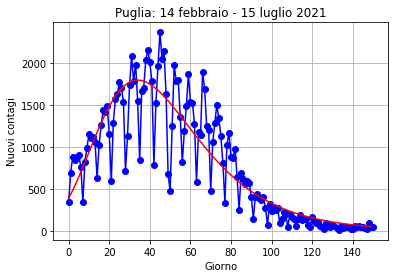

In [8]:
plt.title("Puglia: 14 febbraio - 15 luglio 2021")
plt.xlabel('Giorno')
plt.ylabel('Nuovi contagi')
plt.plot(x, y, marker = 'o', c = 'b')
plt.grid()
ny = np.zeros(150)
for i in range(150):
    ny[i] = diff_Gomp(i,*soln.x)
plt.plot(x[:-1],ny,'r')
plt.show()

In [9]:
import emcee

pos = soln.x * (1.+1e-2* np.random.randn(16, 3))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_pos, args=(x,y))
sampler.run_mcmc(pos, 2000, progress=True);


100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [09:18<00:00,  3.58it/s]


(2000, 16, 3)


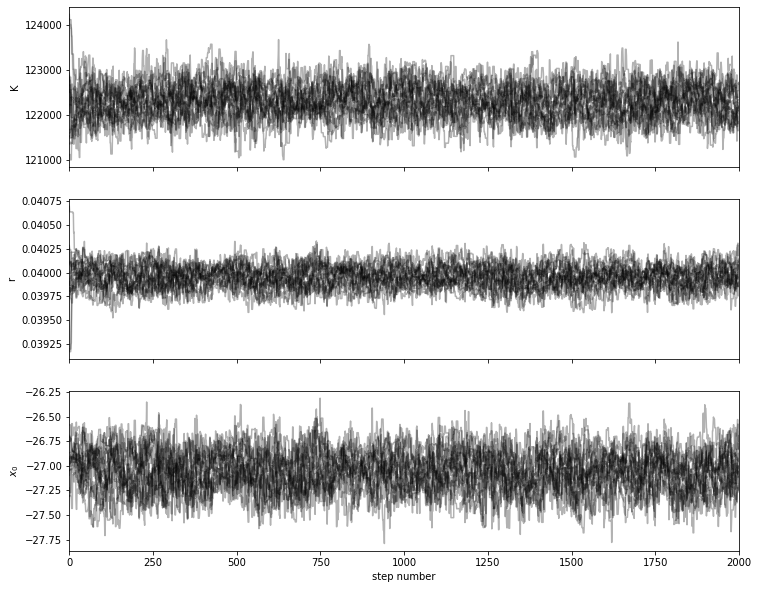

In [10]:
#controllo l'azione del sampler guardando l'evol. temporale dei parametri
fig, axes = plt.subplots(3,figsize=(12,10), sharex=True)
samples = sampler.get_chain()
print(samples.shape)
labels = ["K", "r", "$x_0$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i],color="k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number");

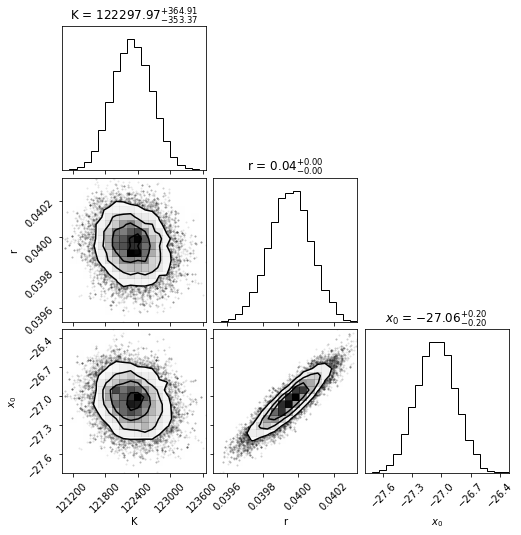

In [11]:
#corner plot -> proiezioni 1d e 2d della prob del posterior dei parametri
import corner
flat_samples = sampler.get_chain(discard=100, flat=True)

fig = corner.corner(flat_samples, labels=labels, show_titles=True)

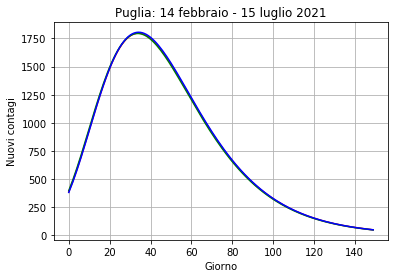

In [12]:
plt.title("Puglia: 14 febbraio - 15 luglio 2021")
plt.xlabel('Giorno')
plt.ylabel('Nuovi contagi')
#plt.plot(x, y, marker = 'o', c = 'b')
plt.grid()
ny = np.zeros(150)
ny_1=np.zeros(150)
ny_2=np.zeros(150)
for i in range(150):
    ny[i] = diff_Gomp(i,*soln.x)
    ny_1[i]=diff_Gomp(i,122334.62-378.12, 0.04, -27.06-0.20)
    ny_2[i]=diff_Gomp(i,122334.62+358.26,0.04, -27.06+0.20)
plt.plot(x[:-1],ny,'r')
plt.plot(x[:-1],ny_1,'g')
plt.plot(x[:-1],ny_2,'b')
plt.show()

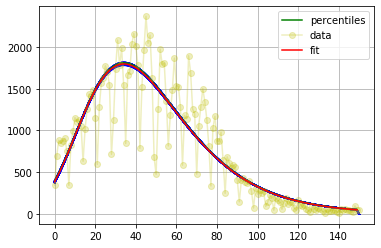

In [163]:
#prendo 400 elementi dalla catena, sottocampionando il posterior
#ho 16 camminatori che fanno 2000 passi per ciascuno dei 3 parametri
a=samples[100:500,1,0:3] #scarto i primi passi di burn in, 
#print(a.shape)->per ogni passo (riga), associo una tripletta (colonne)
K_chain=[None]*400
r_chain=[None]*400
x0_chain=[None]*400
tmp=np.zeros(400)
percentiles=np.zeros(150)
ny_chain=[[0 for c in range(151)] for r in range(400)] #per ogni tripletta (400) ho una y diversa al variare dei giorni (150)

for i in range(400):
    K_chain[i]=a[i,0]
    r_chain[i]=a[i,1]
    x0_chain[i]=a[i,2]
    for j in range(150):
        ny_chain[i][j]=diff_Gomp(j,K_chain[i],r_chain[i],x0_chain[i])
        
    plt.plot(x,ny_chain[i][:],color='b',alpha=i/400)

#prendo gli elementi di ciascuna riga e li porto in un vettore
#print(np.shape(ny_chain))->400 righe (triplette) e 151 colonne (giorni)
for j in range(150):
    for i in range(400):
        tmp[i]=ny_chain[i][j]
    percentiles[j]=np.percentile(tmp,95)
    
plt.plot(x[:-1],percentiles,color='g',label='percentiles',alpha=1)
plt.plot(x,y,color='y',marker='o',label='data',alpha=0.25)    
plt.plot(x[:-1],ny,color='r',label='fit')
plt.legend()
plt.grid()
plt.show()
        